### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

In [1]:
# !pip install wandb
# ! pip install wandb --upgrade

In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

In [4]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [5]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [6]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import hashlib
model_save_path = BASE_PATH / 'models'

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [13]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"
# train_df_path = Path.cwd().parent.parent / "data" / "interim" / "train_and_valid_set"
# df_train = pd.read_pickle(train_df_path / "train_and_valid_set.pkl")

In [14]:
# df_train.sample()

# Log some hyperparameters

In [15]:
n_samples_per_class = 800
one_output_neuron = False
random_seed = 1
positive_index = 1

In [16]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0, seed=random_seed)

In [17]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [18]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [19]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [20]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

In [21]:
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    800
 1.0    800
 Name: count, dtype: int64,
 1600)

In [22]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [23]:
idx=0

In [24]:
shuffled_balanced_train_df = balanced_train_df.sample(frac = 1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac = 1)

Present label: 0.0
Last clip: 15.0
../../data/raw/recordings/OSFL/recording-817014.flac 0.0 3.0


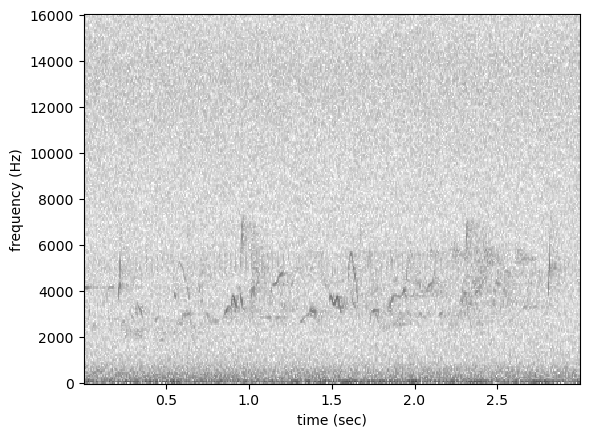

In [25]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [26]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_absence', 'target_presence'], dtype='object'),
 Index(['target_absence', 'target_presence'], dtype='object'))

In [27]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = True


In [28]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [29]:
class_list

['target_absence', 'target_presence']

In [30]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


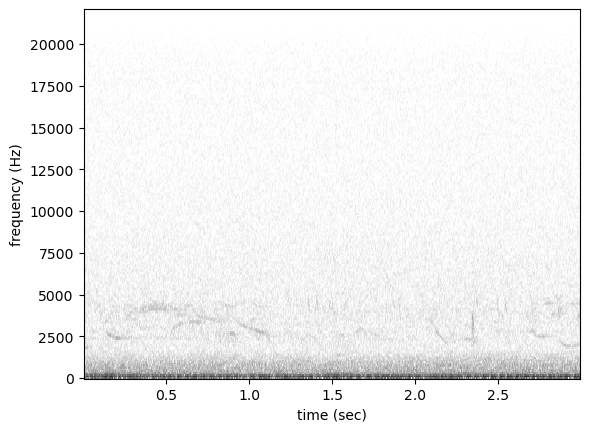

In [31]:
show_sample_from_df(present=True)

In [32]:
print(f'model.device is: {model.device}')

model.device is: mps


In [33]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [34]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    config={
    "epochs":8,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    "positive_index": positive_index,
    "balanced_valid_set": True,
    }
)


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [35]:
shuffled_balanced_valid_df.value_counts()

target_absence  target_presence
0.0             1.0                500
1.0             0.0                500
Name: count, dtype: int64

In [36]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 8,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 0 [batch 0/25, 0.00%] 
	DistLoss: 0.714
Metrics:
Epoch: 0 [batch 10/25, 40.00%] 
	DistLoss: 0.699
Metrics:
Epoch: 0 [batch 20/25, 80.00%] 
	DistLoss: 0.703
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 1 [batch 0/25, 0.00%] 
	DistLoss: 0.715
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 1 [batch 10/25, 40.00%] 
	DistLoss: 0.714
Metrics:
Epoch: 1 [batch 20/25, 80.00%] 
	DistLoss: 0.710
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 2 [batch 0/25, 0.00%] 
	DistLoss: 0.698
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 2 [batch 10/25, 40.00%] 
	DistLoss: 0.694
Metrics:
Epoch: 2 [batch 20/25, 80.00%] 
	DistLoss: 0.711
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
model.valid_metrics

{0: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 1: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 2: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 3: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 4: {'confusion_matrix': array([[  0, 500],
         [  0, 500]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 5: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 6: {'confusion_matrix': 

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [ ]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_{dt}")

In [ ]:
best_model.valid_metrics

{0: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 1: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 2: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 3: {'confusion_matrix': array([[500,   0],
         [500,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 4: {'confusion_matrix': array([[  0, 500],
         [  0, 500]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5}}

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence, and the ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

Intuitively this shouldn't matter - the classes are still being matched up to the same labels. 
I think there are two things happening here:
1. When the metrics are calculated, opso or sklearn expects that the positive class will be at the 1st index and the negative class will be at the 0th index. This makes sense - since that would make the result of argmax equal to 1 for the present class and 0 for the absent class. 

This still leaves the question of why the metrics would look better when considering the absent class as the positive class rather than the other way around. There are a few things going on here:
- In the training set, there are the same number of present clips as absent clips but in the validation set there are far more absent clips than present clips. 
- When we considered the absent class to be the target class, the scores were higher. This might suggest that the model is better at predicting absent than it is at predicting presence. I could test this theory by measuring the metrics only on the absent class, then only on the present class.

Why could this be?
- It might be that there are more incorrectly labelled present clips than there are absent clips.  If noisy present labels are the issue, then that's a relatively quick fix. 

I can now check the effect of cleaning the dataset. 

In [ ]:
model.loss_hist

{0: 0.71486336,
 1: 0.7009159,
 2: 0.71224934,
 3: 0.7267849,
 4: 0.70805204,
 5: 0.7110256,
 6: 0.7359516,
 7: 0.7059812}

In [ ]:
train_df.head()

target_absence  \
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0                  1.0   
                                                  1.5        4.5                  1.0   
                                                  3.0        6.0                  1.0   
                                                  4.5        7.5                  1.0   
                                                  6.0        9.0                  1.0   

                                                                       target_presence  
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0                   0.0  
                                                  1.5        4.5                   0.0  
                                                  3.0        6.0                   0.0  
                                                  4.5        7.5                   0.0  
                                                  6.0        9.0                   0.0

In [ ]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

In [ ]:
from opensoundscape.ml.cnn import load_model
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [ ]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
torch.hub.list('kitzeslab/bioacoustics-model-zoo')

Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['BirdNET', 'Perch', 'SeparationModel', 'YAMNet', 'rana_sierrae_cnn']

In [ ]:
valid_dataset.label_df

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4399.mp3  0.0        3.0                  1.0   
                                                   1.5        4.5                  1.0   
                                                   3.0        6.0                  1.0   
                                                   4.5        7.5                  1.0   
                                                   6.0        9.0                  1.0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-826128... 40.5       43.5                 1.0   
                                                   42.0       45.0                 0.0   
                                                   43.5       46.5                 0.0   
../../data/raw/recordings/OSFL/recording-826131... 0.0        3.0                  1.0   
                                                   3.0        6.0                  0.0   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4399.mp3  0.0        3.0                   0.0  
                                                   1.5        4.5                   0.0  
                                                   3.0        6.0                   0.0  
                                                   4.5        7.5                   0.0  
                                                   6.0        9.0                   0.0  
...                                                                                 ...  
../../data/raw/recordings/OSFL/recording-826128... 40.5       43.5                  0.0  
                                                   42.0       45.0                  1.0  
                                                   43.5       46.5                  1.0  
../../data/raw/recordings/OSFL/recording-826131... 0.0        3.0                   0.0  
                                                   3.0        6.0                   1.0  

[11544 rows x 2 columns]

In [ ]:
sample_preds = model.predict(valid_dataset.label_df).sample(frac=0.1)

  0%|          | 0/11544 [00:00<?, ?it/s]

Sometimes the model isn't changing its prdictions at all with different inputs. 

In [ ]:
# model.generate_samples(sample)

In [43]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▄▅▆▇█
loss,▄▁▃▆▂▃█▂
epoch,7
loss,0.70598
